In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../src/")

In [428]:
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import xrscipy.signal as dsp
import gsw

from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter("ignore")

# set up figure params
sns.set(style='ticks', context='poster')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [429]:
from niwtools.tools import *
from niwtools.qc import qc_turbulence, qc_velocity
# from niwtools.niwtools.qc import qc_turbulence, qc_velocity

In [430]:
events = {'A':{'floatids':['7779a','7781a','7783a','7786a','7787a','7788a'],'times':slice('2016-08-28','2016-09-04')},
         'C': {'floatids':['7781a','7786a','7788a'],'times':slice('2016-10-02','2016-10-11')},
         'D': {'floatids':['7779a','7781a','7786a','7788a'],'times':slice('2016-10-17','2016-11-03')},
         'E': {'floatids':['7779a','7787a'],'times':slice('2016-10-27','2016-11-05')}
         }

In [431]:
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs['time'] = pd.to_datetime(cfs.time.values)

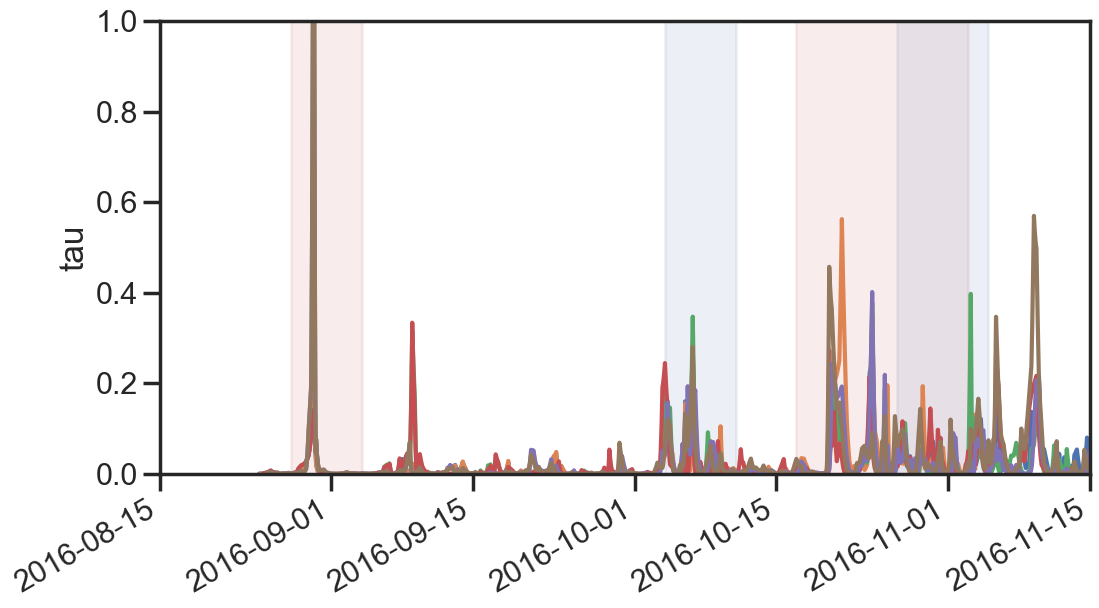

In [432]:
for floatid in ['7779a','7781a','7783a','7786a','7787a','7788a']:
    cfs.sel(floatid=floatid).tau.plot()
plt.fill_between(['2016-08-28','2016-09-04'],y1=0,y2=5,alpha=0.1, color='r')
plt.fill_between(['2016-10-04','2016-10-11'],y1=0,y2=5,alpha=0.1, color='b')
plt.fill_between(['2016-10-17','2016-11-03'],y1=0,y2=5,alpha=0.1, color='r')
plt.fill_between(['2016-10-27','2016-11-05'],y1=0,y2=5,alpha=0.1, color='b')

plt.xlim('2016-08-15','2016-11-15')
plt.ylim(0,1)
plt.title(None)
plt.xlabel(None)

plt.savefig('../figures/events/overview.pdf')

In [411]:
for event in events.keys():
    plt.figure()
    for floatid in events[event]['floatids']:
        raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
        raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1);
        raw = raw.sel(time=events[event]['times'])
        cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
        cfs = cfs.sel(floatid=f'{floatid}')
        raw = add_cfs_data(raw, floatid)
        h= raw.plot.scatter(x='lon',y='lat',hue='tau',s=4,add_guide=False, robust=True)
        plt.annotate(raw.floatid,(raw.isel(time=-1).lon,raw.isel(time=-1).lat),
                     xytext=(-5, -5), textcoords='offset points', fontsize=15)
    plt.colorbar(h)

    fig.savefig(f'../figures/events/maps/map_{event}.pdf')
    plt.close()

In [433]:
for event in events.keys():
    fig,ax = plt.subplots(2,1, sharex=True)
    cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
    for floatid in events[event]['floatids']:
        raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
        raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1)

        raw = raw.sel(time=events[event]['times'])
        cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
        cfs = cfs.sel(floatid=f'{floatid}')
        raw = add_cfs_data(raw, floatid)
        f = gsw.f(40.7)/(2*np.pi)
        raw = bandpass_velocity(raw, 0.75*f, 1.25*f)
        raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
        mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)
        rho0=raw.rho0.mean()
        raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2) # that gonna be in [J m^{-3}]
        raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)
        raw['hkeNI_ml'] = raw.hkeNI.where(raw.z > raw.mld).mean(dim='z')
    #     h= raw.plot.scatter(x='lon',y='lat',hue='tau',s=4,add_guide=False, robust=True)
    #     plt.annotate(raw.floatid,(raw.isel(time=-1).lon,raw.isel(time=-1).lat),xytext=(-5, 5), textcoords='offset points')
        
        raw.taudotu.plot(label=raw.floatid, ax=ax[0])
        raw.hkeNI_ml.plot(label=raw.floatid, ax=ax[1])
        ax[0].set_xlabel(None)
        ax[1].set_xlabel(None)
#         ax[1].set_xlabel(None)
        ax[1].legend()
    
    fig.savefig(f'../figures/events/timeseries/timeseries_{event}.pdf')
    plt.close()
    # plt.colorbar(h)